In [40]:
import random
import os

def generate_data(nodes_number, x_range, y_range, seed):
    if seed is not None:
        random.seed(seed)

    data = []
    used_coordinates = set()

    while len(data) < nodes_number:
        x = random.randint(x_range[0], x_range[1])
        y = random.randint(y_range[0], y_range[1])

        if (x, y) not in used_coordinates:
            used_coordinates.add((x, y))
            data.append((len(data) + 1, x, y))
    return data

def write_to_file(filename, data):
    with open(filename, "w") as f:
        for entry in data:
            f.write(f"{entry[0]} {entry[1]} {entry[2]}\n")


NODES_NUMBER = 5000
X_RANGE = (0, 5000)
Y_RANGE = (0, 5000)
SEED = 1
data = generate_data(NODES_NUMBER, X_RANGE, Y_RANGE, SEED)


filename = "TSP.txt"
if os.path.exists(filename):
    os.remove(filename)

write_to_file(filename, data)

print(f"Randomly generated '{NODES_NUMBER}' Cities and written to '{filename}'")

Randomly generated '5000' Cities and written to 'TSP.txt'


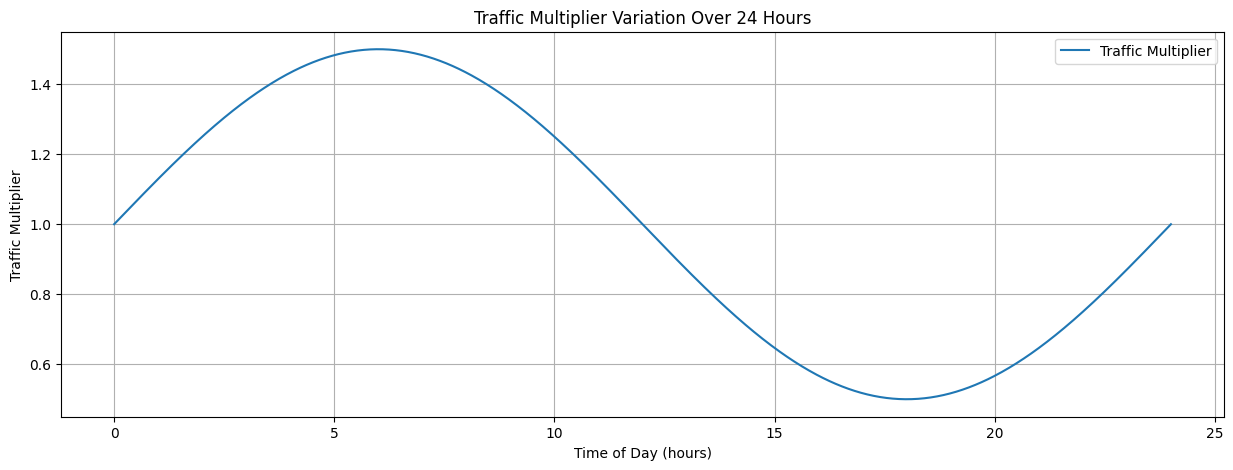

In [38]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.linspace(0, 24, 1000)
TRAFFIC_FUNCTION = 1 + 0.5 * np.sin(hours / 24 * 2 * np.pi)

plt.figure(figsize=(15, 5))
plt.plot(hours, TRAFFIC_FUNCTION, label="Traffic Multiplier")
plt.xlabel("Time of Day (hours)")
plt.ylabel("Traffic Multiplier")
plt.title("Traffic Multiplier Variation Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import cycle
from collections import deque
import pandas as pd
import os
import time
from tqdm import tqdm  # Import tqdm for progress bar

os.environ["OMP_NUM_THREADS"] = "4"

def get_city():
    cities = []
    with open("TSP.txt") as f:
        for i in f.readlines():
            node_city_val = i.split()
            cities.append(
                [node_city_val[0], float(node_city_val[1]), float(node_city_val[2])]
            )
    return cities

def calculate_travel_time(cityA, cityB, time):
    base_distance = math.sqrt(
        math.pow(cityB[1] - cityA[1], 2) + math.pow(cityB[2] - cityA[2], 2)
    )
    traffic_multiplier = 1 + 0.5 * np.sin(time / 24 * 2 * np.pi)
    travel_time = base_distance * traffic_multiplier
    return travel_time

def calculate_distance_matrix(cities):
    n = len(cities)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distance = calculate_travel_time(cities[i], cities[j], 0)
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix

def calculate_total_time(solution, distance_matrix):
    total_time = 0
    for i in range(len(solution) - 1):
        cityA = solution[i]
        cityB = solution[i + 1]
        total_time += distance_matrix[cityA][cityB]
    cityA = solution[0]
    cityB = solution[-1]
    total_time += distance_matrix[cityB][cityA]
    return total_time

def cluster_cities(cities, k):
    coordinates = np.array([[city[1], city[2]] for city in cities])
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(coordinates)
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(kmeans.labels_):
        clusters[label].append(idx)
    return clusters, kmeans.labels_

def nearest_neighbor_path(cluster, distance_matrix):
    unvisited = set(cluster)
    path = [unvisited.pop()]
    while unvisited:
        nearest_city = min(unvisited, key=lambda city: distance_matrix[path[-1]][city])
        path.append(nearest_city)
        unvisited.remove(nearest_city)
    return path

def connect_clusters(clusters, distance_matrix):
    paths = []
    for cluster in clusters:
        path = nearest_neighbor_path(cluster, distance_matrix)
        paths.append(path)
    connected_path = [city for path in paths for city in path]
    return connected_path

def generate_initial_solution(cities, distance_matrix):
    clusters, labels = cluster_cities(cities, K_CLUSTERS)
    solution = connect_clusters(clusters, distance_matrix)
    return solution, labels

def generate_neighbors(solution, distance_matrix, sample_size):
    neighbors = []
    for _ in range(sample_size):
        neighbor = solution[:]
        move_type = random.choice(["swap", "reverse", "insert"])
        if move_type == "swap":
            i, j = random.sample(range(1, len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        elif move_type == "reverse":
            i, j = sorted(random.sample(range(1, len(neighbor)), 2))
            neighbor[i:j] = reversed(neighbor[i:j])
        elif move_type == "insert":
            i, j = random.sample(range(1, len(neighbor)), 2)
            if i < j:
                neighbor.insert(j, neighbor.pop(i))
            else:
                neighbor.insert(i, neighbor.pop(j))
        neighbors.append((neighbor, calculate_total_time(neighbor, distance_matrix)))
    return neighbors

def tabu_search(
    initial_solution, distance_matrix, tabu_tenure, iterations, sample_size, isTest
):
    best_solution = initial_solution
    best_cost = calculate_total_time(initial_solution, distance_matrix)
    current_solution = initial_solution
    current_cost = best_cost
    tabu_list = deque(maxlen=tabu_tenure)

    iteration_costs = []  # List to store costs at each 10th iteration

    print(f"Initial Solution Cost: {best_cost}")

    for iteration in tqdm(range(iterations)):  # Add progress bar here
        neighborhood = generate_neighbors(
            current_solution, distance_matrix, sample_size
        )
        neighborhood = sorted(neighborhood, key=lambda x: x[1])

        for candidate in neighborhood:
            if tuple(candidate[0]) not in tabu_list:
                current_solution = candidate[0]
                current_cost = candidate[1]
                tabu_list.append(tuple(candidate[0]))
                break

        if current_cost < best_cost:
            best_solution = current_solution
            best_cost = current_cost
        else:
            current_solution = best_solution
            current_cost = best_cost

        if iteration % 10 == 0:
            iteration_costs.append(current_cost)  # Store the cost every 10 iterations

    return best_solution, best_cost, iteration_costs  # Return the iteration costs

def drawMap(cities, path, labels, k):
    plt.figure(figsize=(50, 50))
    colors = cycle(plt.cm.tab20.colors)

    for j in range(len(cities)):
        plt.plot(cities[j][1], cities[j][2], "ro")
        # plt.annotate(cities[j][0], (cities[j][1], cities[j][2]))

    color_map = {i: next(colors) for i in range(k)}
    for i in range(len(path) - 1):
        first = path[i]
        second = path[i + 1]
        cluster_color = color_map[labels[first]]
        plt.plot(
            [cities[first][1], cities[second][1]],
            [cities[first][2], cities[second][2]],
            color=cluster_color,
        )
    first = path[0]
    second = path[-1]
    plt.plot(
        [cities[first][1], cities[second][1]],
        [cities[first][2], cities[second][2]],
        "blue",
    )
    plt.show()

def main():
    global K_CLUSTERS
    K_CLUSTERS = 10
    TABU_TENURE = 15
    ITERATIONS = 1000

    cities = get_city()

    distance_matrix = calculate_distance_matrix(cities)
    initial_solution, labels = generate_initial_solution(cities, distance_matrix)

    best_solution, best_cost, iteration_costs = tabu_search(
        initial_solution,
        distance_matrix,
        TABU_TENURE,
        ITERATIONS,
        int(len(cities) / K_CLUSTERS),
        False
    )

    print("\n----------------------------------------------------------------")
    print(
        f"Initial solution cost: {calculate_total_time(initial_solution, distance_matrix)}"
    )
    print(f"Best solution cost: {best_cost}")
    print("----------------------------------------------------------------\n")

    drawMap(cities, best_solution, labels, K_CLUSTERS)

    # Plotting the iteration costs
    plt.figure(figsize=(12, 8))
    plt.plot(range(0, ITERATIONS, 10), iteration_costs, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations')
    plt.grid(True)
    plt.show()

def analyze_performance():
    cities = get_city()
    distance_matrix = calculate_distance_matrix(cities)

    results = []
    for k_clusters in [10, 20, 30]:
        global K_CLUSTERS
        K_CLUSTERS = k_clusters
        for tabu_tenure in [10, 15, 20]:
            for iterations in [500, 1000, 1500]:
                start_time = time.time()
                initial_solution, labels = generate_initial_solution(
                    cities, distance_matrix
                )
                best_solution, best_cost, _ = tabu_search(
                    initial_solution,
                    distance_matrix,
                    tabu_tenure,
                    iterations,
                    int(len(cities) / K_CLUSTERS),
                    True
                )
                end_time = time.time()
                computation_time = end_time - start_time

                initial_solution_cost = calculate_total_time(
                    initial_solution, distance_matrix
                )

                results.append(
                    {
                        "K_CLUSTERS": k_clusters,
                        "TABU_TENURE": tabu_tenure,
                        "ITERATIONS": iterations,
                        "Initial Solution Cost": initial_solution_cost,
                        "Best Solution Cost": best_cost,
                        "Computation Time": computation_time,
                    }
                )

    df = pd.DataFrame(results)

    # Visualization
    plt.figure(figsize=(12, 8))
    for k_clusters in df["K_CLUSTERS"].unique():
        subset = df[df["K_CLUSTERS"] == k_clusters]
        plt.plot(
            subset["ITERATIONS"],
            subset["Best Solution Cost"],
            label=f"K_CLUSTERS={k_clusters}",
        )
    plt.xlabel("Iterations")
    plt.ylabel("Best Solution Cost")
    plt.title("Best Solution Cost vs Iterations for Different K_CLUSTERS")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    for tabu_tenure in df["TABU_TENURE"].unique():
        subset = df[df["TABU_TENURE"] == tabu_tenure]
        plt.plot(
            subset["ITERATIONS"],
            subset["Computation Time"],
            label=f"TABU_TENURE={tabu_tenure}",
        )
    plt.xlabel("Iterations")
    plt.ylabel("Computation Time (seconds)")
    plt.title("Computation Time vs Iterations for Different TABU_TENURE")
    plt.legend()
    plt.show()

main()


Initial Solution Cost: 35666.31190373879


100%|██████████| 500/500 [00:15<00:00, 32.68it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 1000/1000 [00:29<00:00, 33.74it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 1500/1500 [00:45<00:00, 33.05it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 500/500 [00:15<00:00, 33.16it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 1000/1000 [00:30<00:00, 33.23it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 1500/1500 [00:45<00:00, 32.86it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 500/500 [00:15<00:00, 33.24it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 1000/1000 [00:30<00:00, 32.33it/s]


Initial Solution Cost: 35666.31190373879


100%|██████████| 1500/1500 [00:45<00:00, 32.98it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 500/500 [00:07<00:00, 65.30it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 1000/1000 [00:15<00:00, 65.58it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 1500/1500 [00:22<00:00, 66.48it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 500/500 [00:08<00:00, 59.27it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 1000/1000 [00:16<00:00, 61.71it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 1500/1500 [00:22<00:00, 67.48it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 500/500 [00:07<00:00, 68.39it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 1000/1000 [00:16<00:00, 62.09it/s]


Initial Solution Cost: 39754.10877047445


100%|██████████| 1500/1500 [00:22<00:00, 67.37it/s]


Initial Solution Cost: 41514.48052184338


100%|██████████| 500/500 [00:04<00:00, 103.48it/s]


Initial Solution Cost: 41514.48052184338


100%|██████████| 1000/1000 [00:09<00:00, 100.98it/s]


Initial Solution Cost: 41514.48052184338


100%|██████████| 1500/1500 [00:14<00:00, 101.45it/s]


Initial Solution Cost: 41514.48052184338


100%|██████████| 500/500 [00:05<00:00, 99.34it/s] 


Initial Solution Cost: 41514.48052184338


100%|██████████| 1000/1000 [00:09<00:00, 102.47it/s]


Initial Solution Cost: 41514.48052184338


100%|██████████| 1500/1500 [00:14<00:00, 100.20it/s]


Initial Solution Cost: 41514.48052184338


100%|██████████| 500/500 [00:05<00:00, 98.80it/s] 


Initial Solution Cost: 41514.48052184338


100%|██████████| 1000/1000 [00:09<00:00, 103.36it/s]


Initial Solution Cost: 41514.48052184338


100%|██████████| 1500/1500 [00:14<00:00, 101.14it/s]


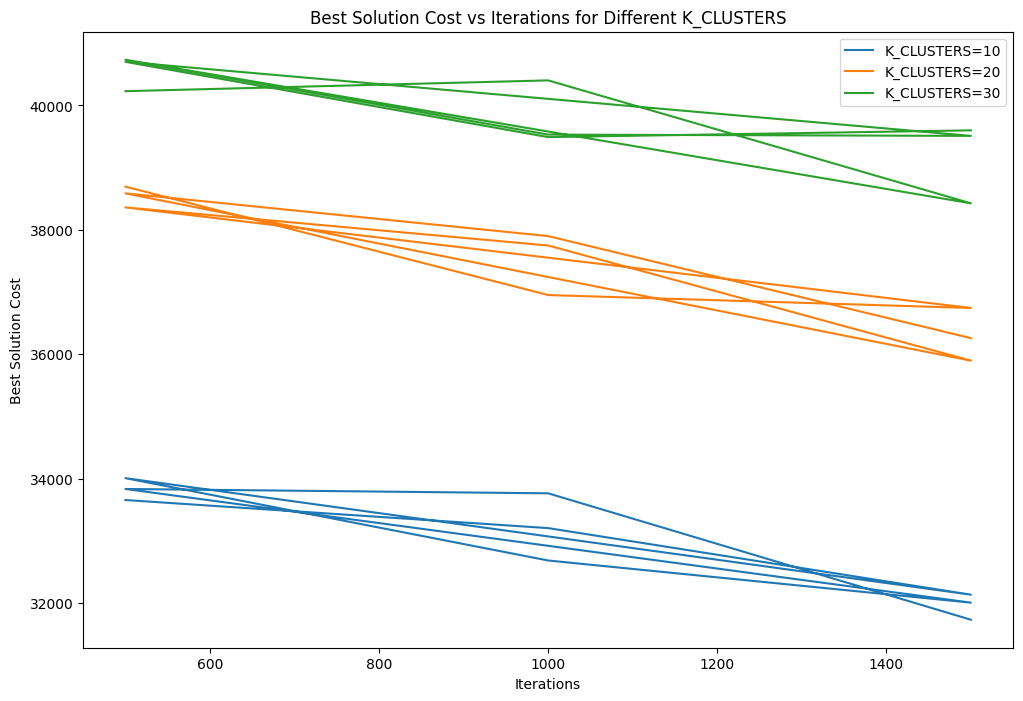

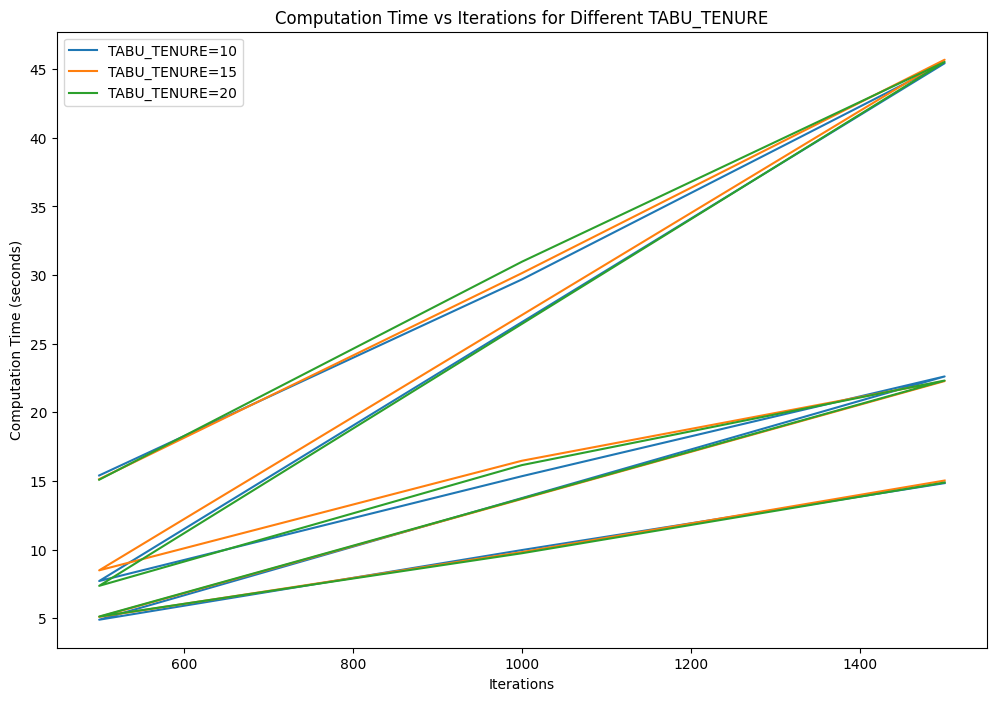

In [33]:
analyze_performance()